#Sample-based implementation of Blahut-Arimoto iteration

In [1]:
#load taxonomy example
using RateDistortionDecisionMaking, DataFrames, Gadfly, Distributions

#set up taxonomy example
include("TaxonomyExample.jl")
o_vec, o_strings, a_vec, a_strings, p_o, U = setuptaxonomy()

#pre-compute utilities, find maxima
U_pre, Umax = setuputilityarrays(a_vec,o_vec,U)

#initialize p(a) uniformly
num_acts = length(a_vec)
pa_init = ones(num_acts)/num_acts;


## Compute BA solutions sampling-based and compare against theoretical results


In [2]:

#Performs rejection sampling with a constant (scaled uniform) envelope
#using a softmax acceptance-rejection criterion.
#prop_dist .. proposal distribution (must be an instance of type ::Distribution)
#nsamps ..... desired number of samples (scalar)
#maxsteps ... maximum number of acceptance-rejection steps (scalar, must be ≧ nsamps)
#β .......... softmax parameter
#lh ......... likelihood value (vector of length N)
#maxlh ...... maximum value that the likelihood can take (scalar)
function rej_samp_const(prop_dist::Distribution, nsamps::Integer, maxsteps::Integer, β::Number, lh::Vector, maxlh::Number)    
    #initialize
    samps = zeros(nsamps)
    acc_cnt = 0  #acceptance-counter
    if(maxsteps < nsamps)
        maxsteps = nsamps
    end
    
    k=0 #use this to make sure that k is still available after the loop
    for k in 1:maxsteps
        u=rand(1) #sample from uniform between (0,1)
        index = rand(prop_dist) #sample from proposal
        
        ratio = exp(β*lh[index])/exp(β*maxlh)
        if u[1]<ratio #explicit indexing is needed to get a float, since the >= can not handle arrays
            #if we enter here, accept the sample                       
            acc_cnt = acc_cnt + 1     
            samps[acc_cnt] = index
            
            if(acc_cnt == nsamps)
                #we have enough samples, exit loop
                break
            end
        end
    end
    
    if(k==maxsteps)
        warn("[RejSampConst] Maximum number of steps reached - number of samples is potentially lower than nsamps!\n")
    end
    
    #store all accepted samples (this can be less than nsamps if maxsteps is too low or acceptance-rate is low)
    samples = samps[1:acc_cnt]
    
    #compute acceptance ratio
    acc_ratio = acc_cnt/k
    
    return samples, acc_ratio
end

rej_samp_const (generic function with 1 method)

In [3]:
#marginal is simply represented by counters (i.e. by frequencies)
function init_marginal_representation_ctrs(pa_init::Vector)
    return pa_init
end

#this updates the marginal over actions p(a) using a counter-representation
#this function counts the number of times each action-index occurs in sampled_indices
#these counts are then added to the current marginal_ctrs. Optionally, the counters are reset
#before adding the new samples (=hard forgetting).
function update_marginal_ctrs(sampled_indices::Vector, marginal_ctrs::Vector; reset_ctrs::Bool=false)    
    #TODO: perhaps replace hard-resetting with an exponential decay?
    
    p_ctrs = marginal_ctrs
    card_p = length(p_ctrs)
    
    #reset counters for marginal? (make sure every entry is non-zero!)
    if reset_ctrs
        p_ctrs = ones(card_p)/card_p
    end

    #update marginal counters using a histogram to do the counting (bin-borders have to be set manually!)
    e,p_counts = hist(sampled_indices,0.5:1:(card_p+0.5))    #TODO: do you really need a hist here (this should also work easier?)           
    p_ctrs = p_ctrs + p_counts
    
    #normalize to get the updated marginal
    p_sampled = p_ctrs / sum(p_ctrs)
    
    return p_sampled, p_ctrs  #return the probability-vector, but also the representation of the marginal (as counts)
end



#function for BA sampling
#burnin_ratio specifies the ratio of outer iterations that will not count
#towards computation of the final marginal distribution (counters will be blocked)
#reset_marginal_ctrs specifies whether the marginal is computed with the samples of the last
#iteration only (=hard forgetting by resetting counters) or whether the marginal
#is computed with all samples of all iterations (=no forgetting)
function BAsampling(pa_init::Vector, β::Number, U_pre::Matrix, Umax::Vector, po::Vector, 
                    nsteps_marginalupdate::Integer, nsteps_conditionalupdate::Integer;
                    burnin_ratio::Real=0.7, max_rejsamp_steps::Integer=200,
                    compute_performance::Bool=false, performance_as_dataframe::Bool=false,
                    performance_per_iteration::Bool=false,
                    init_marg_func::Function=init_marginal_representation_ctrs,
                    update_marg_func::Function=update_marginal_ctrs, update_func_args...)
    
    #compute cardinality, check size of U_pre
    card_a = length(pa_init)
    card_o = length(po)
    if size(U_pre) != (card_a, card_o)
        error("Size mismatch of U_pre and pa_init or po!")
    end
    
    #check that burnin_ratio is really a ratio
    if (burnin_ratio < 0) || (burnin_ratio > 1)
        error("burnin_ratio must be a number between 0 and 1.")
    end
    
    #if performance measures don't need to be returned, don't compute them per iteration
    if compute_performance==false
        performance_per_iteration = false
    end 
    #preallocate if necessary
    if performance_per_iteration 
        I_i = zeros(maxiter)
        Ha_i = zeros(maxiter)
        Hago_i = zeros(maxiter)
        EU_i = zeros(maxiter)
        RDobj_i = zeros(maxiter)
    end
    
    #initialize sampling distributions
    po_dist = Categorical(po) #proposal distribution    
    pago_ctrs = ones(card_a, card_o) #counters for conditional distribution   
    pa_sampled = pa_init #marginal distribution
    
    #initialize the marginal representation
    pa_ctrs = init_marg_func(pa_init)

    burnin_triggered=false
    #outer loop - in each iteration the marginal is updated
    iter=0
    for iter in 1:nsteps_marginalupdate        
        a_samples = zeros(nsteps_conditionalupdate)  #this will hold the samples from p(a|o) during inner loop
        
        #inner loop - in each step a sample is drawn from the conditional and stored for
        #for the batch-update of the marginal
        for j in 1:nsteps_conditionalupdate
            #draw an o sample
            o_samp = rand(po_dist)

            #draw a sample from p(a|o) using the current estimate of p(a) as proposal distribution using rejection sampling
            ago_samp, acc_ratio = rej_samp_const(Categorical(pa_sampled), 1, max_rejsamp_steps, β, U_pre[:,o_samp], Umax[o_samp])
            a_samples[j] = ago_samp[1]

            #update conditional counters
            pago_ctrs[ago_samp, o_samp] += 1
        end
        
        #very simple burn-in: simply reset counters
        if (iter >(nsteps_marginalupdate)*burnin_ratio) && (!burnin_triggered)
            burnin_triggered = true
            pago_ctrs = ones(card_a, card_o)                                
        end

        #update marginal with samples drawn in inner loop
        pa_sampled, pa_ctrs = update_marg_func(a_samples, pa_ctrs; update_func_args...)       
        
        
        #compute entropic quantities (if requested with additional parameter)
        if performance_per_iteration
            #compute sample-based conditional p(a|o)
            pago_sampled = zeros(card_a, card_o)
            for i in 1:card_o
                pago_sampled[:,i] = pago_ctrs[:,i] / sum(pago_ctrs[:,i])
            end
            I_i[iter], Ha_i[iter], Hago_i[iter], EU_i[iter], RDobj_i[iter] = analyzeBAsolution(po, pa_sampled, pago_sampled, U_pre, β)
        end
    end

    #compute conditionals using the sample-counts of the previous inner loops
    #the burn-in parameter specifies how many of the inner loops are discarded
    pago_sampled = zeros(card_a, card_o)
    for i in 1:card_o
        pago_sampled[:,i] = pago_ctrs[:,i] / sum(pago_ctrs[:,i])
    end

    
    #return results
    if compute_performance == false
        return pago_sampled, pa_sampled
    else            
        if performance_per_iteration == false
            #compute performance measures for final solution
            I, Ha, Hago, EU, RDobj = analyzeBAsolution(po, pa_sampled, pago_sampled, U_pre, β)
        else
            #"cut" valid results from preallocated vector
            I = I_i[1:iter]
            Ha = Ha_i[1:iter]
            Hago = Hago_i[1:iter]
            EU = EU_i[1:iter]
            RDobj = RDobj_i[1:iter]
        end

        #if needed, transform to data frame
        if performance_as_dataframe == false
            return pago_sampled, pa_sampled, I, Ha, Hago, EU, RDobj
        else
            performance_df = performancemeasures2DataFrame(I, Ha, Hago, EU, RDobj)
            return pago_sampled, pa_sampled, performance_df 
        end
    end
    
end

#TODO: perhaps use an ϵ criterion on the marginal to specify convergence
#but then you have to take care of the burn-in (if marginal converges early,
#conditionals might be based on too few samples). Also, the value of ϵ will
#have different effects when forgetting is on or off


BAsampling (generic function with 1 method)

In [53]:
#example call and also plot evolution of performance measueres
maxiter = 10000
β = 1.2
nsteps_marg = 500
nsteps_cond = 750
pago_s,pa_s,perf = BAsampling(pa_init, β, U_pre, Umax, p_o, nsteps_marg, nsteps_cond,
                              burnin_ratio=0.7, max_rejsamp_steps=500, reset_ctrs=false,
                              compute_performance=true, performance_as_dataframe=true, performance_per_iteration=true)

plt_cond = visualizeBAconditional(pago_s,a_vec,o_vec)

#instead of using a range of β-values (as for the standard-performance plot), 
#use a vector indicating the iteration
niter = size(perf,1)
plt_perf_entropy, plt_perf_utility, plt_rateutility = plotperformancemeasures(perf,[1:niter],
                                                      suppress_vis=true, xlabel_perf="Iteration")

display(vstack(plt_perf_entropy, plt_perf_utility))
display(plt_cond)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 β 
 
 
 -600 
 -500 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 1100 
 -500 
 -480 
 -460 
 -440 
 -420 
 -400 
 -380 
 -360 
 -340 
 -320 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 920 
 940 
 960 
 980 
 1000 
 -500 
 0 
 500 
 1000 
 -500 
 -450 
 -400 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 950 
 1000 
 
 
 
 E[U] 
 RU_obj 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M21.1,63.76 L 21.29 62.42 21.49 62.03 21.68 61.82 21.88 61.73 22.07 61.6 22.27 61.51 22.46 61.43 22.66 61.4 22.85 61.32 23.05 61.31 23.24 61.29 23.44 61.3 23.63 61.32 23.83 61.32 24.02 61.33 24.22 61.35 24.41 61.29 24.61 61.29 24.8 61.27 25 61.25 25.19 61.26 25.39 61.26 25.59 61.23 25.78 61.22 25.98 61.2 26.17 61.18 26.37 61.19 26.56 61.18 26.76 61.18 26.95 61.17 27.15 61.18 27.34 61.17 27.54 61.19 27.73 61.19 27.93 61.19 28.12 61.19 28.32 61.19 28.51 61.19 28.71 61.18 28.9 61.21 29.1 61.21 29.29 61.22 29.49 61.22 29.68 61.22 29.88 61.22 30.07 61.23 30.27 61.22 30.47 61.22 30.66 61.21 30.86 61.23 31.05 61.23 31.25 61.25 31.44 61.26 31.64 61.26 31.83 61.28 32.03 61.28 32.22 61.28 32.42 61.28 32.61 61.29 32.81 61.29 33 61.29 33.2 61.29 33.39 61.29 33.59 61.28 33.78 61.28 33.98 61.28 34.17 61.29 34.37 61.28 34.56 61.28 34.76 61.29 34.96 61.29 35.15 61.29 35.35 61.29 35.54 61.29 35.74 61.29 35.93 61.28 36.13 61.29 36.32 61.29 36.52 61.29 36.71 61.29 36.91 61.28 37.1 61.29 37.3 61.29 37.49 61.3 37.69 61.29 37.88 61.29 38.08 61.29 38.27 61.29 38.47 61.3 38.66 61.3 38.86 61.3 39.05 61.29 39.25 61.3 39.44 61.29 39.64 61.3 39.84 61.3 40.03 61.3 40.23 61.3 40.42 61.3 40.62 61.3 40.81 61.3 41.01 61.3 41.2 61.3 41.4 61.31 41.59 61.31 41.79 61.31 41.98 61.31 42.18 61.31 42.37 61.32 42.57 61.32 42.76 61.32 42.96 61.32 43.15 61.32 43.35 61.32 43.54 61.32 43.74 61.32 43.93 61.32 44.13 61.32 44.33 61.32 44.52 61.32 44.72 61.33 44.91 61.33 45.11 61.33 45.3 61.33 45.5 61.33 45.69 61.33 45.89 61.33 46.08 61.33 46.28 61.33 46.47 61.33 46.67 61.33 46.86 61.33 47.06 61.33 47.25 61.33 47.45 61.33 47.64 61.33 47.84 61.33 48.03 61.32 48.23 61.32 48.42 61.32 48.62 61.32 48.81 61.32 49.01 61.32 49.21 61.33 49.4 61.33 49.6 61.33 49.79 61.34 49.99 61.34 50.18 61.34 50.38 61.34 50.57 61.34 50.77 61.34 50.96 61.34 51.16 61.34 51.35 61.34 51.55 61.34 51.74 61.34 51.94 61.34 52.13 61.34 52.33 61.34 52.52 61.34 52.72 61.34 52.91 61.34 53.11 61.34 53.3 61.33 53.5 61.33 53.7 61.34 53.89 61.34 54.09 61.34 54.28 61.34 54.48 61.34 54.67 61.34 54.87 61.34 55.06 61.34 55.26 61.34 55.45 61.35 55.65 61.34 55.84 61.34 56.04 61.35 56.23 61.35 56.43 61.35 56.62 61.35 56.82 61.35 57.01 61.35 57.21 61.35 57.4 61.35 57.6 61.35 57.79 61.35 57.99 61.35 58.18 61.35 58.38 61.35 58.58 61.35 58.77 61.35 58.97 61.36 59.16 61.36 59.36 61.36 59.55 61.35 59.75 61.35 59.94 61.35 60.14 61.36 60.33 61.36 60.53 61.36 60.72 61.36 60.92 61.36 61.11 61.37 61.31 61.37 61.5 61.37 61.7 61.37 61.89 61.37 62.09 61.37 62.28 61.37 62.48 61.37 62.67 61.37 62.

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Observation o 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|o) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 
 
 Action a

## Compare sampling-solutions against theoretical results

In [5]:
#compute theoretical result for rate-dutility curve
ε = 0.000001 #convergence critetion for BAiterations
maxiter = 10000
β_sweep = [0.01:0.05:3]
nβ = length(β_sweep)

#preallocate
I = zeros(nβ)
Ha = zeros(nβ)
Hago = zeros(nβ)
EU = zeros(nβ)
RDobj = zeros(nβ)

#sweep through β values and perfomr Blahut-Arimoto iterations for each value
for i=1:nβ    
    pago, pa, I[i], Ha[i], Hago[i], EU[i], RDobj[i] = BAiterations(pa_init, β_sweep[i], U_pre, Umax, p_o, ε, maxiter,compute_performance=true)  
end

#show rate-utility curve (shaded region is theoretically infeasible)
perf_res_analytical = performancemeasures2DataFrame(I, Ha, Hago, EU, RDobj);  
plot_perf_entropy, plot_perf_util, plot_rateutility = plotperformancemeasures(perf_res_analytical, β_sweep, suppress_vis=true);
display(plot_rateutility)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 I(A;O) [bits] 
 
 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 -5 
 0 
 5 
 10 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path d="M125.06,7.12 L 124.96 7.14 124.84 7.16 124.71 7.19 124.57 7.22 124.4 7.25 124.21 7.29 123.99 7.34 123.74 7.39 123.46 7.46 123.14 7.53 122.78 7.62 122.36 7.71 121.9 7.83 121.37 7.96 120.77 8.11 120.09 8.29 119.32 8.49 118.46 8.73 117.48 9 116.39 9.32 115.16 9.68 113.79 10.09 112.26 10.57 110.55 11.11 93.02 16.94 89.09 18.26 84.34 19.92 78.34 22.07 75.01 23.3 72.98 24.08 70.8 24.95 68.46 25.91 51.38 33.23 49.78 33.93 48.13 34.7 46.42 35.52 44.66 36.4 42.87 37.34 41.06 38.34 33.98 42.48 32.71 43.25 31.45 44.07 30.19 44.92 28.81 45.93 25.65 48.37 23.53 50.12 22.86 50.72 22.23 51.34 21.63 51.97 21.07 52.63 20.56 53.31 20.09 54 19.67 54.71 19.31 55.43 19 56.17 18.76 56.91 18.58 57.66 18.55 57.87 18.55 57.87 18.55 7.12 18.55 7.12 18.58 7.12 18.76 7.12 19 7.12 19.31 7.12 19.67 7.12 20.09 7.12 20.56 7.12 21.07 7.12 21.63 7.12 22.23 7.12 22.86 7.12 23.53 7.12 25.65 7.12 28.81 7.12 30.19 7.12 31.45 7.12 32.71 7.12 33.98 7.12 41.06 7.12 42.87 7.12 44.66 7.12 46.42 7.12 48.13 7.12 49.78 7.12 51.38 7.12 68.46 7.12 70.8 7.12 72.98 7.12 75.01 7.12 78.34 7.12 84.34 7.12 89.09 7.12 93.02 7.12 110.55 7.12 112.26 7.12 113.79 7.12 115.16 7.12 116.39 7.12 117.48 7.12 118.46 7.12 119.32 7.12 120.09 7.12 120.77 7.12 121.37 7.12 121.9 7.12 122.36 7.12 122.78 7.12 123.14 7.12 123.46 7.12 123.74 7.12 123.99 7.12 124.21 7.12 124.4 7.12 124.57 7.12 124.71 7.12 124.84 7.12 124.96 7.12 125.06 7.12 z"/>
 
 
 <path fill="none" d="M18.55,57.87 L 18.55 57.87 18.58 57.66 18.76 56.91 19 56.17 19.31 55.43 19.67 54.71 20.09 54 20.56 53.31 21.07 52.63 21.63 51.97 22.23 51.34 22.86 50.72 23.53 50.12 25.65 48.37 28.81 45.93 30.19 44.92 31.45 44.07 32.71 43.25 33.98 42.48 41.06 38.34 42.87 37.34 44.66 36.4 46.42 35.52 48.13 34.7 49.78 33.93 51.38 33.23 68.46 25.91 70.8 24.95 72.98 24.08 75.01 23.3 78.34 22.07 84.34 19.92 89.09 18.26 93.02 16.94 110.55 11.11 112.26 10.57 113.79 10.09 115.16 9.68 116.39 9.32 117.48 9 118.46 8.73 119.32 8.49 120.09 8.29 120.77 8.11 121.37 7.96 121.9 7.83 122.36 7.71 122.78 7.62 123.14 7.53 123.46 7.46 123.74 7.39 123.99 7.34 124.21 7.29 124.4 7.25 124.57 7.22 124.71 7.19 124.84 7.16 124.96 7.14 125.06 7.12"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 -3.0 
 -2.9 
 -2.8 
 -2.7 
 -2.6 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 4.1 
 4.2 
 4.3 
 4.4 
 4.5 
 4.6 
 4.7 
 4.8 
 4.9 
 5.0 
 5.1 
 5.

In [6]:
#run the smapling for different temperatures and repeat each run n-times
#then plot these results against the rate-utility curve (based on the closed-form solutions)
βrange_samp = [0.1, 0.25, 0.5, 0.8, 1.2, 1.4, 1.6, 2]
#βrange_samp = [1.2, 2]

nruns = 3; #number of runs per β point

nsteps_marg = 500
nsteps_cond = 750
burnin_ratio = 0.8
max_rejsamp_steps=500 #maximum number of steps for sampling from the conditional


nconditions = size(βrange_samp,1)*nruns
I_sampled = zeros(2*nconditions)
Ha_sampled = zeros(2*nconditions)
EU_sampled = zeros(2*nconditions)
βval = zeros(2*nconditions)
ResetCtrs = falses(2*nconditions)

#first run with reset_ctrs to false
reset_ctrs = false #if true, the ctrs for the marginal are reset in each iteration (="hard" forgetting)
for b in 1:nconditions
    println("BA Sampling, run $b of $(2*nconditions)")
    β = βrange_samp[ceil(b/nruns)]
    
    pago_s, pa_s, I, Ha, Hago, EU, RDobj = BAsampling(pa_init, β, U_pre, Umax, p_o, nsteps_marg, nsteps_cond,
                                               reset_ctrs=reset_ctrs, burnin_ratio=burnin_ratio,
                                               max_rejsamp_steps=max_rejsamp_steps, compute_performance=true)
    
    I_sampled[b] = I
    Ha_sampled[b] = Ha
    EU_sampled[b] = EU
    βval[b] = β
    ResetCtrs[b] = reset_ctrs
end

#second run with reset_ctrs to true
reset_ctrs = true #if true, the ctrs for the marginal are reset in each iteration (="hard" forgetting)
for b in 1:nconditions
    println("BA Sampling, run $(nconditions+b) of $(2*nconditions)")
    β = βrange_samp[ceil(b/nruns)]
    
    pago_s, pa_s, I, Ha, Hago, EU, RDobj = BAsampling(pa_init, β, U_pre, Umax, p_o, nsteps_marg, nsteps_cond,
                                               reset_ctrs=reset_ctrs, burnin_ratio=burnin_ratio,
                                               max_rejsamp_steps=max_rejsamp_steps, compute_performance=true)
    
    I_sampled[nconditions+b] = I
    Ha_sampled[nconditions+b] = Ha
    EU_sampled[nconditions+b] = EU
    βval[nconditions+b] = β
    ResetCtrs[nconditions+b] = reset_ctrs
end

#wrap data in DataFrame for convenient plotting
res_sampled = DataFrame(β=βval, I_ao=I_sampled, H_a=Ha_sampled, E_U=EU_sampled, Forgetting=ResetCtrs)



#TODO: also try non-uniform initializations for p(a)

BA Sampling, run 1 of 48
BA Sampling, run 2 of 48
BA Sampling, run 3 of 48
BA Sampling, run 4 of 48
BA Sampling, run 5 of 48
BA Sampling, run 6 of 48
BA Sampling, run 7 of 48
BA Sampling, run 8 of 48
BA Sampling, run 9 of 48
BA Sampling, run 10 of 48
BA Sampling, run 11 of 48
BA Sampling, run 12 of 48
BA Sampling, run 13 of 48
BA Sampling, run 14 of 48
BA Sampling, run 15 of 48
BA Sampling, run 16 of 48
BA Sampling, run 17 of 48
BA Sampling, run 18 of 48
BA Sampling, run 19 of 48
BA Sampling, run 20 of 48
BA Sampling, run 21 of 48
BA Sampling, run 22 of 48
BA Sampling, run 23 of 48
BA Sampling, run 24 of 48
BA Sampling, run 25 of 48
BA Sampling, run 26 of 48
BA Sampling, run 27 of 48
BA Sampling, run 28 of 48
BA Sampling, run 29 of 48
BA Sampling, run 30 of 48
BA Sampling, run 31 of 48
BA Sampling, run 32 of 48
BA Sampling, run 33 of 48
BA Sampling, run 34 of 48
BA Sampling, run 35 of 48
BA Sampling, run 36 of 48
BA Sampling, run 37 of 48
BA Sampling, run 38 of 48
BA Sampling, run 39 o

,β,I_ao,H_a,E_U,Forgetting
1,0.1,0.008632804112549172,4.202745913316081,0.4849345336086244,false
2,0.1,0.00789519542533933,4.20447708295746,0.48060505557209826,false
3,0.1,0.008901436514170349,4.210547411218864,0.47730363504650025,false
4,0.25,0.04521116743248719,4.147970181322973,0.6656326125511908,false
5,0.25,0.043352088733451005,4.097545225723001,0.6754398399892406,false
6,0.25,0.04290894848686962,4.126431180394203,0.6748552438919282,false
7,0.5,0.19389523271627845,3.7625456456418243,1.0527273068323661,false
8,0.5,0.19567681299913303,3.794248180015014,1.045233741172519,false
9,0.5,0.18695120414008784,3.8200826719545797,1.0288737113436688,false
10,0.8,0.5162977169712859,3.6841827428863625,1.4119647400431314,false


In [17]:
#compute theoretical result for same set of temperatures
ε = 0.000001 #convergence critetion for BAiterations
maxiter = 10000
nβ = length(βrange_samp)

#preallocate
I = zeros(nβ)
Ha = zeros(nβ)
Hago = zeros(nβ)
EU = zeros(nβ)
RDobj = zeros(nβ)

#sweep through β values and perfomr Blahut-Arimoto iterations for each value
for i=1:nβ    
    pago, pa, I[i], Ha[i], Hago[i], EU[i], RDobj[i] = BAiterations(pa_init, βrange_samp[i], U_pre, Umax, p_o, ε, maxiter,compute_performance=true)  
end

#show rate-utility curve (shaded region is theoretically infeasible)
perf_res_analytical_samp = performancemeasures2DataFrame(I, Ha, Hago, EU, RDobj)
perf_res_analytical_samp[:β] = βrange_samp;

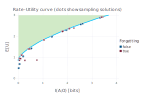

In [26]:
#plot the solutions from the sampling runs into the (analytical) rate-utility plot
plot(Guide.ylabel("E[U]"), Guide.xlabel("I(A;O) [bits]"),
     Guide.title("Rate-Utility curve (dots show sampling solutions)"), BAtheme(), BAdiscretecolorscale(2),
     layer(res_sampled,y="E_U",x="I_ao",Geom.point,color="Forgetting"),
     layer(perf_res_analytical_samp,y="E_U",x="I_ao",Geom.point),
     layer(perf_res_analytical,y="E_U",x="I_ao",Geom.line),
     layer(perf_res_analytical,y="E_U",x="I_ao",ymin="E_U",ymax=ones(nconditions)*maximum(perf_res_analytical[:E_U]),
     Geom.ribbon,BAtheme(default_color=color("green")))
    )

#TODO: instead of changing the default_color, rather use this (but make the color lighter somehow)
# - also use this in the libarary then.
#lowlight_color=c->color("green")

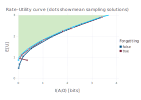

In [37]:
#compute the mean for each group of points (that were produced with the same beta and same forgetting setting)
res_samp_aggregated = aggregate(res_sampled, [:β,:Forgetting], mean)

#plot the mean-solutions from the sampling runs into the (analytical) rate-utility plot
plot(Guide.ylabel("E[U]"), Guide.xlabel("I(A;O) [bits]"),
     Guide.title("Rate-Utility curve (dots show mean sampling solutions)"), BAtheme(), BAdiscretecolorscale(2),
     layer(res_samp_aggregated,y="E_U_mean",x="I_ao_mean",Geom.point,Geom.line(preserve_order=true),color="Forgetting"),
     layer(perf_res_analytical_samp,y="E_U",x="I_ao",Geom.point),
     layer(perf_res_analytical,y="E_U",x="I_ao",Geom.line),
     layer(perf_res_analytical,y="E_U",x="I_ao",ymin="E_U",ymax=ones(nconditions)*maximum(perf_res_analytical[:E_U]),
     Geom.ribbon,BAtheme(default_color=color("green")))
    )

In [9]:
#TODO: store the plots

In [10]:
#TODO: try changing the number of inner-/outer-loop iterations
#TODO: try changing the burn-in ratio, try soft-forgetting, etc...

#TODO: forgetting seems to do better than no forgetting (in terms of being closer to the rate-utility curve),
#but it also seems that the points with forgetting tend to have a lower I(A;O) (and also a lower E[U]) - even though
#the temperatures are the same. Therefore maybe some soft-forgetting is better (exp. decay).
#Probably with not forgetting the solution is biased.

#TODO: try to come up with an ϵ-criterion for the marginal (just like in the analytical Blahut-Arimoto).
#Once the marginal has converged, keep iterating (without updates for the marginal?) until the conditional
#has converged as well (use only these samples, i.e. after convergence of the marginal, to compute the conditional?)

#TODO: it definitely seems as if a high burn-in ratio > 0.7 helps improve the results, particluarly for the case with 
#forgetting

In [11]:
#Try using a parametric model for the marginal distribution p(x) and then adjusting its parameters
# -) That could potentially also work for all kinds of continuous problems
#    +) can't be compared against the theoretical optimum then anymore though
# -) For instance, adjust the parameters by moment-matching, minimizing the KL to the empirical dist, etc.
# -) This would still be prone to the curse of dimensionality as it needs a huge number of samples for each adjustment step
# -) Maybe there are even relations to EM or something similar if you choose a certain adjustment mechanism?
# -) In this case, one could even use the parametric model and derive an (online?) gradient update rule w.r.t. the objective
# -) Why would you not directly assume a parametric model for the conditionals and derive an update rule (like Felix)?
#    +) perhaps its easier to update the marginal (less samples, more robust, etc.)?

#What happens when you do smapling with annealing (starting with high β, but then reducing it)?
# -) do you get closer (on average) to the rate-distortion curve?
# -) do you converge faster (overall number of samples)?
# -) have the solutions that we see here that are off the curve converged already?!? (what about the others?)
# -) What happens when you do sampling with annealing but you move through a phase-transition
#     +) Is the annealing at all helpful then?
# -) How would sampling with annealing be justified in terms of having limited resources
#     +) Perhaps by allowing allocation of a pool of resources - initially allocate many, but over time require less?